# Building a LangGraph Agent

The following example demonstrates building an agent using LangGraph. Zep is used to personalize agent responses based on information learned from prior conversations. 

The agent implements:
- persistance of new chat turns to Zep and recall of relevant Facts using the most recent messages.
- an in-memory MemorySaver to maintain agent state. We use this to add recent chat history to the agent prompt. As an alternative, you could use Zep for this. 

**IMPRTANT**: You should consider truncating MemorySaver's chat history as by default LangGraph state grows unbounded. We've included this in our example below. See the LangGraph documentation for insight.

## Install dependencies
```shell
pip install zep-cloud langchain-openai langgraph ipywidgets
```

In [1]:
import logging
import os
import sys
import uuid
from contextlib import suppress
from typing import Annotated

from dotenv import load_dotenv
from IPython.display import Image, display
from typing_extensions import TypedDict

load_dotenv()

True

In [2]:
def setup_logging():
    logger = logging.getLogger()
    logger.setLevel(logging.ERROR)
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(logging.ERROR)
    formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)
    return logger


logger = setup_logging()

## LangSmith integration (Optional)

If you'd like to trace your agent using LangSmith, ensure that you have a `LANGSMITH_API_KEY` set in your environment.

Then set `os.environ['LANGCHAIN_TRACING_V2'] = 'false'` to `true`.


In [3]:
os.environ['LANGCHAIN_TRACING_V2'] = 'false'
os.environ['LANGCHAIN_PROJECT'] = 'Zep LangGraph Tutorial'

## Configure Zep

Ensure that you've configured the following API key in your environment. We're using Zep's Async client here, but we could also use the non-async equivalent.

```bash
ZEP_API_KEY=
```

In [4]:
from zep_cloud.client import AsyncZep
from zep_cloud import Message

zep = AsyncZep(api_key=os.environ.get('ZEP_API_KEY'))

In [5]:
from langchain_core.messages import AIMessage, SystemMessage, trim_messages
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, add_messages
from langgraph.prebuilt import ToolNode

## Using Zep's Search as a Tool
This is an example of a simple Tool that searches Zep for facts related to a user, irrespective which chat session. We also include relevant facts from the current session in the Agent's prompt.

In [22]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    user_name: str
    session_id: str


@tool
async def search_facts(state: State, query: str, limit: int = 5):
    """Search for facts in all conversations had with a user.
    
    Args:
        state (State): The Agent's state.
        query (str): The search query.
        limit (int): The number of results to return. Defaults to 5.

    Returns:
        list: A list of facts that match the search query.
    """
    return await zep.memory.search_sessions(user_id=state['user_name'], text=query, limit=limit, search_scope="facts")


tools = [search_facts]

tool_node = ToolNode(tools)

llm = ChatOpenAI(model='gpt-4o-mini', temperature=0).bind_tools(tools)

## Chatbot Function Explanation

The chatbot uses Zep to provide context-aware responses. Here's how it works:

1. **Context Retrieval**: It retrieves relevant facts for the user's current conversation (session). Zep uses the most recent messages to determine what facts to retrieve.

2. **System Message**: It constructs a system message incorporating the facts retrieved in 1., setting the context for the AI's response.

3. **Message Persistence**: After generating a response, it asynchronously adds the user and assistant messages to Zep. New Facts are created and existing Facts updated using this new information.

4. **Messages in State**: We use LangGraph state to store the most recent messages and add these to the Agent prompt. We limit the message list to the most recent 3 messages for demonstration purposes. You may also use Zep's chat history for this purpose. 

This approach enables the chatbot to maintain context across interactions and provide personalized responses based on the user's history and preferences stored in Zep.

In [23]:
async def chatbot(state: State):
    memory = await zep.memory.get(state["session_id"])
    facts_string = ""
    if memory.relevant_facts:
        facts_string = "\n".join([f.fact for f in memory.relevant_facts])

    system_message = SystemMessage(
        content=f"""You are a compassionate mental health bot and caregiver. Review information about the user and their prior conversation below and respond accordingly.
        Keep responses empathetic and supportive. And remember, always prioritize the user's well-being and mental health.

        Facts about the user and their conversation:
        {facts_string or 'No facts about the user and their conversation'}"""
    )

    messages = [system_message] + state["messages"]

    response = await llm.ainvoke(messages)

    # Add the new chat turn to the Zep graph
    messages_to_save = [
        Message(
            role_type="user",
            role=state["user_name"],
            content=state["messages"][-1].content,
        ),
        Message(role_type="assistant", content=response.content),
    ]

    await zep.memory.add(
        session_id=state["session_id"],
        messages=messages_to_save,
    )

    # Truncate the chat history to keep the state from growing unbounded
    # In this example, we going to keep the state small for demonstration purposes
    # We'll use Zep's Facts to maintain conversation context
    state["messages"] = trim_messages(
        state["messages"],
        strategy="last",
        token_counter=len,
        max_tokens=3,
        start_on="human",
        end_on=("human", "tool"),
        include_system=True,
    )

    logger.info(f"Messages in state: {state['messages']}")

    return {"messages": [response]}

## Setting up the Agent

This section sets up the Agent's LangGraph graph:

1. **Graph Structure**: It defines a graph with nodes for the agent (chatbot) and tools, connected in a loop.

2. **Conditional Logic**: The `should_continue` function determines whether to end the graph execution or continue to the tools node based on the presence of tool calls.

3. **Memory Management**: It uses a MemorySaver to maintain conversation state across turns. This is in addition to using Zep for facts.

In [24]:
graph_builder = StateGraph(State)

memory = MemorySaver()


# Define the function that determines whether to continue or not
async def should_continue(state, config):
    messages = state['messages']
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return 'end'
    # Otherwise if there is, we continue
    else:
        return 'continue'

graph_builder.add_node('agent', chatbot)
graph_builder.add_node('tools', tool_node)

graph_builder.add_edge(START, 'agent')

graph_builder.add_conditional_edges('agent', should_continue, {'continue': 'tools', 'end': END})
graph_builder.add_edge('tools', 'agent')


graph = graph_builder.compile(checkpointer=memory)

Our LangGraph agent graph is illustrated below.

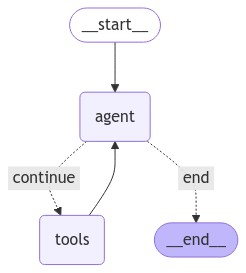

In [25]:
with suppress(Exception):
    display(Image(graph.get_graph().draw_mermaid_png()))

## Running the Agent

We generate a unique user name and thread id (session id) and add these to Zep, associating the Session with the new User.

In [26]:
user_name = 'Daniel_' + uuid.uuid4().hex[:4]
thread_id = uuid.uuid4().hex

await zep.user.add(user_id=user_name)
await zep.memory.add_session(session_id=thread_id, user_id=user_name)

def extract_messages(result):
    output = ""
    for message in result['messages']:
        if isinstance(message, AIMessage):
            role = "assistant"
        else:
            role = result['user_name']
        output += f"{role}: {message.content}\n"
    return output.strip()



async def graph_invoke(message: str, user_name: str, thread_id: str, ai_response_only: bool = True):
    r =  await graph.ainvoke(
        {
            'messages': [
                {
                    'role': 'user',
                    'content': message,
                }
            ],
            'user_name': user_name,
            'session_id': thread_id,
        },
        config={'configurable': {'thread_id': thread_id}},
    )

    if ai_response_only:
        return r['messages'][-1].content
    else:
        return extract_messages(r)


In [27]:
r = await graph_invoke(
    "Hi there?",
    user_name,
    thread_id,
)

print(r)

Hello! How are you feeling today? I'm here to listen and support you.


In [28]:
r = await graph_invoke(
    "I'm fine. But have been a bit stressful lately. Mostly work related. But also my dog.",
    user_name,
    thread_id,
)

print(r)

I'm sorry to hear that you've been feeling stressed. Work can be a significant source of pressure, and it sounds like your dog might be adding to that stress as well. If you feel comfortable sharing, what specifically has been causing you stress at work and with your dog? I'm here to help you through it.


In [29]:
r = await graph_invoke(
    "She's sick. I'm worried about her.",
    user_name,
    thread_id,
)

print(r)

I’m really sorry to hear that your dog is sick. It’s completely understandable to feel worried about her; our pets are like family. Have you been able to take her to the vet? Sometimes getting a professional opinion can help ease some of that worry. I'm here to support you through this.


## Viewing All Conversation Facts

In [30]:
facts = await zep.memory.get_session_facts(session_id=thread_id)

print("\n".join([f"Fact: {fact.fact}" for fact in facts.facts]))

Fact: Daniel's dog is also contributing to his stress.
Fact: Daniel's stress is mostly work-related.
Fact: Daniel has been feeling stressed lately.


In [31]:
r = await graph_invoke(
    "She ate my shoes which were expensive.",
    user_name,
    thread_id,
)

print(r)

That sounds really frustrating, especially on top of everything else you're dealing with. It's tough when our pets do things that add to our stress, especially when it involves something valuable. It’s okay to feel upset about it. How are you managing with everything?


Let's now test whether the Agent is correctly grounded with facts from the prior conversation.

In [32]:
r = await graph_invoke(
    "What are we talking about?",
    user_name,
    thread_id,
)

print(r)

We were discussing the stress you've been feeling lately, particularly related to work and your dog's health. You mentioned that your dog has been sick and also chewed up your expensive shoes, which can be really frustrating. If there's something else on your mind or if you'd like to talk about a different topic, I'm here to listen!


Let's go even further back to determine whether context is kept by referencing a user message that is not currently in the Agent State. Zep will retrieve Facts related to the user's job.

In [33]:
r = await graph_invoke(
    "What have I said about my job?",
    user_name,
    thread_id,
)

print(r)

You've mentioned that you've been feeling stressed lately, and it seems that your job is a significant part of that stress. If you'd like to share more about what's been going on at work, I'm here to listen and help however I can.
